# 1. Import libraries

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import MDAnalysis as mda

import matplotlib as mpl
mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['legend.frameon'] = False
mpl.font_manager.findSystemFonts(fontpaths="/home/marco/.local/share/fonts", fontext="ttf")
mpl.rcParams['font.family'] = 'Oswald'

palette = ['royalblue', 'darkorange','limegreen']

# 2. Basic analysis

## RMSD

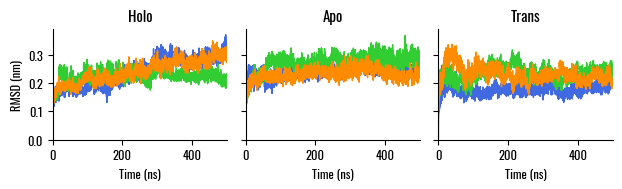

In [10]:
# Load data
time = np.loadtxt('../02-analysis/rmsd_apo_rep1.xvg', usecols=0,comments=['#','@'])
rmsds_holo = np.column_stack((np.loadtxt('../02-analysis/rmsd_holo_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_holo_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_holo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsds_apo = np.column_stack((np.loadtxt('../02-analysis/rmsd_apo_rep1.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsd_apo_rep2.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsd_apo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsds_tran = np.column_stack((np.loadtxt('../02-analysis/rmsd_trans_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_trans_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_trans_rep3.xvg', usecols=1,comments=['#','@'])))

fig,ax = plt.subplots(1,3,figsize=(16/2.54,5/2.54),sharey=True,sharex=True)
for i,r in enumerate([rmsds_holo,rmsds_apo,rmsds_tran]):
    ax[i].plot(time,r[:,0],color=palette[0],label='Rep 1')
    ax[i].plot(time,r[:,1],color=palette[1],label='Rep 2')
    ax[i].plot(time,r[:,2],color=palette[2],label='Rep 3')
    ax[i].set_xlabel('Time (ns)')
    ax[i].set_xlim(0,500)
    ax[i].set_ylim(bottom=0)

ax[0].set_ylabel('RMSD (nm)')
ax[0].set_title('Holo'); ax[1].set_title('Apo'); ax[2].set_title('Trans')
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/RMSD.png',dpi=600,facecolor='white')

## RMSF

In [111]:
def add_helices(ax,botlim=0,w=0.02):
    from matplotlib.patches import Rectangle
    ax.add_patch(Rectangle((3,botlim),36,w,  fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((3,botlim),299,w, fill=True,lw=0,color='darkgrey',zorder=-1))
    ax.add_patch(Rectangle((42,botlim),30,w, fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((77,botlim),35,w, fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((124,botlim),30,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((173,botlim),40,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((218,botlim),36,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((258,botlim),24,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((283,botlim),18,w,fill=True,lw=0,color='k',zorder=0))
    ax.text(20, botlim+w+0.005,"TM1",fontsize=9, ha='center')
    ax.text((3+36+42)/2,botlim+w+0.005,"ICL1",fontsize=9, ha='center',color='darkgrey')
    ax.text(57, botlim+w+0.005,"TM2",fontsize=9, ha='center')
    ax.text((42+30+77)/2, botlim+w+0.005,"ECL1",fontsize=9, ha='center',color='darkgrey')
    ax.text(95, botlim+w+0.005,"TM3",fontsize=9, ha='center')
    ax.text((77+35+124)/2,botlim+w+0.005,"ECL2",fontsize=9, ha='center',color='darkgrey')
    ax.text(139,botlim+w+0.005,"TM4",fontsize=9, ha='center')
    ax.text((124+30+173)/2,botlim+w+0.005,"ECL2",fontsize=9, ha='center',color='darkgrey')
    ax.text(193,botlim+w+0.005,"TM5",fontsize=9, ha='center')
    ax.text((173+40+218)/2,botlim+w+0.005,"ICL3",fontsize=9, ha='center',color='darkgrey')
    ax.text(236,botlim+w+0.005,"TM6",fontsize=9, ha='center')
    ax.text((218+36+258)/2,botlim+w+0.005,"ECL3",fontsize=9, ha='center',color='darkgrey')
    ax.text(270,botlim+w+0.005,"TM7",fontsize=9, ha='center')
    ax.text(292,botlim+w+0.005,"H8", fontsize=9, ha='center')

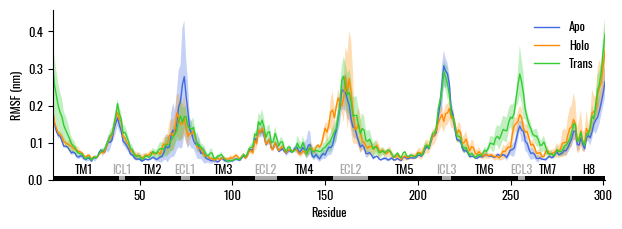

In [112]:
# load data
residues = np.loadtxt('../02-analysis/rmsf_apo_rep1.xvg', usecols=0,comments=['#','@'])

rmsfs_holo = np.column_stack((np.loadtxt('../02-analysis/rmsf_holo_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_holo_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_holo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsfs_apo = np.column_stack((np.loadtxt('../02-analysis/rmsf_apo_rep1.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsf_apo_rep2.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsf_apo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsfs_tran = np.column_stack((np.loadtxt('../02-analysis/rmsf_trans_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_trans_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_trans_rep3.xvg', usecols=1,comments=['#','@'])))

fig,ax = plt.subplots(1,1,figsize=(16/2.54,6/2.54))
ax.plot(residues,rmsfs_apo.mean(axis=1),color=palette[0],label='Apo')
ax.plot(residues,rmsfs_holo.mean(axis=1),color=palette[1],label='Holo')
ax.plot(residues,rmsfs_tran.mean(axis=1),color=palette[2],label='Trans')

ax.fill_between(residues,rmsfs_apo.min(axis=1),
                rmsfs_apo.mean(axis=1)+rmsfs_apo.std(axis=1),color=palette[0],alpha=0.3,edgecolor=None)
ax.fill_between(residues,rmsfs_holo.min(axis=1),
                rmsfs_holo.mean(axis=1)+rmsfs_holo.std(axis=1),color=palette[1],alpha=0.3,edgecolor=None)
ax.fill_between(residues,rmsfs_tran.min(axis=1),
                rmsfs_tran.mean(axis=1)+rmsfs_tran.std(axis=1),color=palette[2],alpha=0.3,edgecolor=None)

add_helices(ax,w=0.01)

ax.set_xlabel('Residue')
ax.set_ylabel('RMSF (nm)')
ax.set_xlim(residues[0],residues[-1])
ax.set_ylim(bottom=0)
ax.legend()
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/RMSF.png',dpi=600,facecolor='white')

# Volume

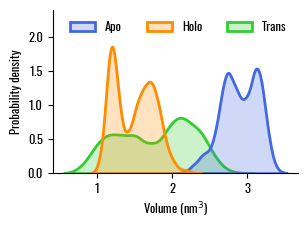

In [107]:
# Load volume data
vol_holo = np.loadtxt('../02-analysis/volume_holo.dat', usecols=1,skiprows=1)/1000
vol_apo = np.loadtxt('../02-analysis/volume_apo.dat', usecols=1,skiprows=1)/1000
vol_tran = np.loadtxt('../02-analysis/volume_trans.dat', usecols=1,skiprows=1)/1000

fig,ax = plt.subplots(1,1,figsize=(8/2.54,6/2.54))
sns.kdeplot(vol_apo,ax=ax,color=palette[0],label='Apo',cut=0, fill=True,zorder=1)
sns.kdeplot(vol_holo,ax=ax,color=palette[1],label='Holo',cut=0, fill=True,zorder=1)
sns.kdeplot(vol_tran,ax=ax,color=palette[2],label='Trans',cut=0, fill=True,zorder=0)
ax.set_xlabel('Volume (nm$^3$)')
ax.set_ylabel('Probability density')
ax.set_ylim(0,2.4)
ax.legend(ncol=3)
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/Volume.png',dpi=600,facecolor='white')

# Angle 241

In [64]:
u_apo = mda.Universe('../01-sim/7XP4/start.pdb','../01-sim/7XP4/cat_50ps.xtc')
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
u_trans = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_50ps.xtc')

# compute the angle of Y241
angles = []
for U in [u_apo,u_holo,u_trans]:
    angle = []
    for _ in U.trajectory:
        v1 = U.select_atoms('resid 241 and name CA').positions[0] - U.select_atoms('resid 241 and name CG CD2 CE2 CZ CE1 CD1').positions[0]
        v2 = U.select_atoms('resid 241 and name CA').positions[0] - U.select_atoms('resid 271 and name CA').positions[0]
        a1 = np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi
        v2 = U.select_atoms('resid 241 and name CA').positions[0] - U.select_atoms('resid 188 and name CA').positions[0]
        a2 = np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi
        angle.append([a1,a2])
    angles.append(np.vstack(angle))

angles = np.stack(angles,axis=0)

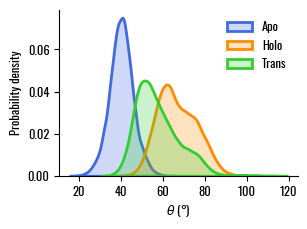

In [106]:
fig,ax = plt.subplots(1,1,figsize=(8/2.54,6/2.54),sharex=True,sharey=True)
sns.kdeplot(x=angles[0,:,0],ax=ax,color=palette[0],label='Apo',cut=0, fill=True)
sns.kdeplot(x=angles[1,:,0],ax=ax,color=palette[1],label='Holo',cut=0, fill=True)
sns.kdeplot(x=angles[2,:,0],ax=ax,color=palette[2],label='Trans',cut=0, fill=True)
ax.legend()
ax.set_xlabel(r'$\theta$ (°)')
ax.set_ylabel('Probability density')
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/angle_Y241.png',dpi=600,facecolor='white')

In [72]:
u_whole = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_whole.xtc')
angle = []
for _ in u_whole.trajectory:
    v1 = u_whole.select_atoms('resid 241 and name CA').positions[0] - u_whole.select_atoms('resid 241 and name CG CD2 CE2 CZ CE1 CD1').positions[0]
    v2 = u_whole.select_atoms('resid 241 and name CA').positions[0] - u_whole.select_atoms('resid 271 and name CA').positions[0]
    a1 = np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi
    v2 = u_whole.select_atoms('resid 241 and name CA').positions[0] - u_whole.select_atoms('resid 188 and name CA').positions[0]
    a2 = np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi
    angle.append([a1,a2])
angles_whole = np.vstack(angle)

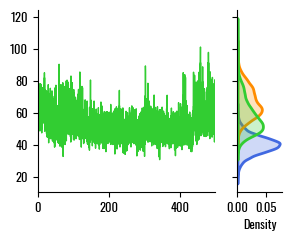

In [99]:
fig,ax = plt.subplots(1,2,figsize=(8/2.54,6/2.54),sharey=True,gridspec_kw={'width_ratios': [4, 1]})
ts = 0.05
i=0
ax[0].plot(np.arange(0,500,ts),angles_whole[int(500*i/ts):int(500*(1+i)/ts),0],color=palette[2])
ax[0].set_xlim(0,500)
sns.kdeplot(y=angles[0,:,0],ax=ax[1],color=palette[0],label='Apo',cut=0, fill=True)
sns.kdeplot(y=angles[1,:,0],ax=ax[1],color=palette[1],label='Holo',cut=0, fill=True)
sns.kdeplot(y=angles[2,:,0],ax=ax[1],color=palette[2],label='Trans',cut=0, fill=True)
sns.despine()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


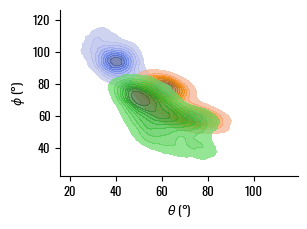

In [73]:
fig,ax = plt.subplots(1,1,figsize=(8/2.54,6/2.54),sharex=True,sharey=True)
sns.kdeplot(x=angles[0,:,0],y=angles[0,:,1],ax=ax,color=palette[0],label='Apo',cut=0, fill=True,alpha=.7)
sns.kdeplot(x=angles[1,:,0],y=angles[1,:,1],ax=ax,color=palette[1],label='Holo',cut=0, fill=True,alpha=.7)
sns.kdeplot(x=angles_whole[:,0],y=angles_whole[:,1],ax=ax,color=palette[2],label='Trans',cut=0, fill=True,alpha=.7)
ax.set_xlabel(r'$\theta$ (°)')
ax.set_ylabel(r'$\phi$ (°)')
ax.legend(loc='upper left')
sns.despine()
fig.tight_layout()

# Distance between ECL1 and ECL3

In [102]:
u_apo = mda.Universe('../01-sim/7XP4/start.pdb','../01-sim/7XP4/cat_50ps_fit.xtc')
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
u_trans = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_50ps.xtc')
ECL3 = "resid 253 to 259"
ECL1 = "resid 71  to 79"

distances = []
for U in [u_apo,u_holo,u_trans]:
    d = []
    for _ in U.trajectory:
        d.append(np.linalg.norm(U.select_atoms(ECL3).center_of_mass() - U.select_atoms(ECL1).center_of_mass(),2))
    distances.append(np.array(d))

distances = np.column_stack(distances)

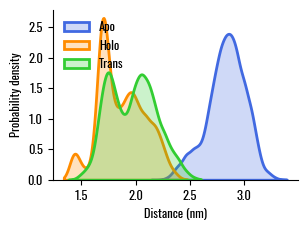

In [104]:
fig,ax = plt.subplots(1,1,figsize=(8/2.54,6/2.54))
sns.kdeplot(distances[:,0]/10,ax=ax,color=palette[0],label='Apo',cut=0, fill=True)
sns.kdeplot(distances[:,1]/10,ax=ax,color=palette[1],label='Holo',cut=0, fill=True)
sns.kdeplot(distances[:,2]/10,ax=ax,color=palette[2],label='Trans',cut=0, fill=True)
ax.set_xlabel('Distance (nm)')
ax.set_ylabel('Probability density')
ax.legend(loc='upper left')
sns.despine()
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


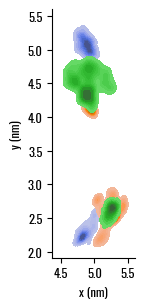

In [101]:
u_apo = mda.Universe('../01-sim/7XP4/start.pdb','../01-sim/7XP4/cat_50ps_fit.xtc')
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
u_trans = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_50ps.xtc')

fig,ax = plt.subplots(1,1,figsize=(8/2.54,8/2.54))
systems = ['Apo','Holo','Trans']
for i,U in enumerate([u_apo,u_holo,u_trans]):
    pos1,pos3 = [], []
    for _ in U.trajectory:
        pos1.append(U.select_atoms(ECL1).center_of_mass()/10)
        pos3.append(U.select_atoms(ECL3).center_of_mass()/10)
    pos1 = np.vstack(pos1)
    pos3 = np.vstack(pos3)
    sns.kdeplot(x=pos1[:,0],y=pos1[:,1],fill=True,color=palette[i],ax=ax,label=systems[i])
    sns.kdeplot(x=pos3[:,0],y=pos3[:,1],fill=True,color=palette[i],ax=ax)
ax.set_aspect('equal')
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.legend()
sns.despine()
fig.tight_layout()